# APS PMDI canister fluorescence : sump scans

Post processing of X-ray canister fluorescence data with KI solutions.
Fourth step - Apply signal trapping corrections to different scans and produce usable graphs.

Data collected by Daniel Duke, Lingzhe Rao & Alan Kastengren
@ Advanced Photon Source, Argonne National Laboratory, Lemont, Illinois USA
November, 2022.

    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2022 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 21/03/2023
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
import sys
print(sys.version)

3.11.2 (main, Feb 16 2023, 03:15:23) [Clang 14.0.0 (clang-1400.0.29.202)]


In [2]:
import h5py, glob, copy, os
import numpy as np
import scipy.optimize, scipy.integrate, scipy.interpolate
import skimage.morphology
import matplotlib.pyplot as plt
%matplotlib notebook

# Get my functions from the last two notebooks, which are saved into a Python module.
from dd_xrf_functions import *
from dd_xrf_sigtrap import *

## Develop a background mask for the sump and nozzle orifice

<IPython.core.display.Javascript object>


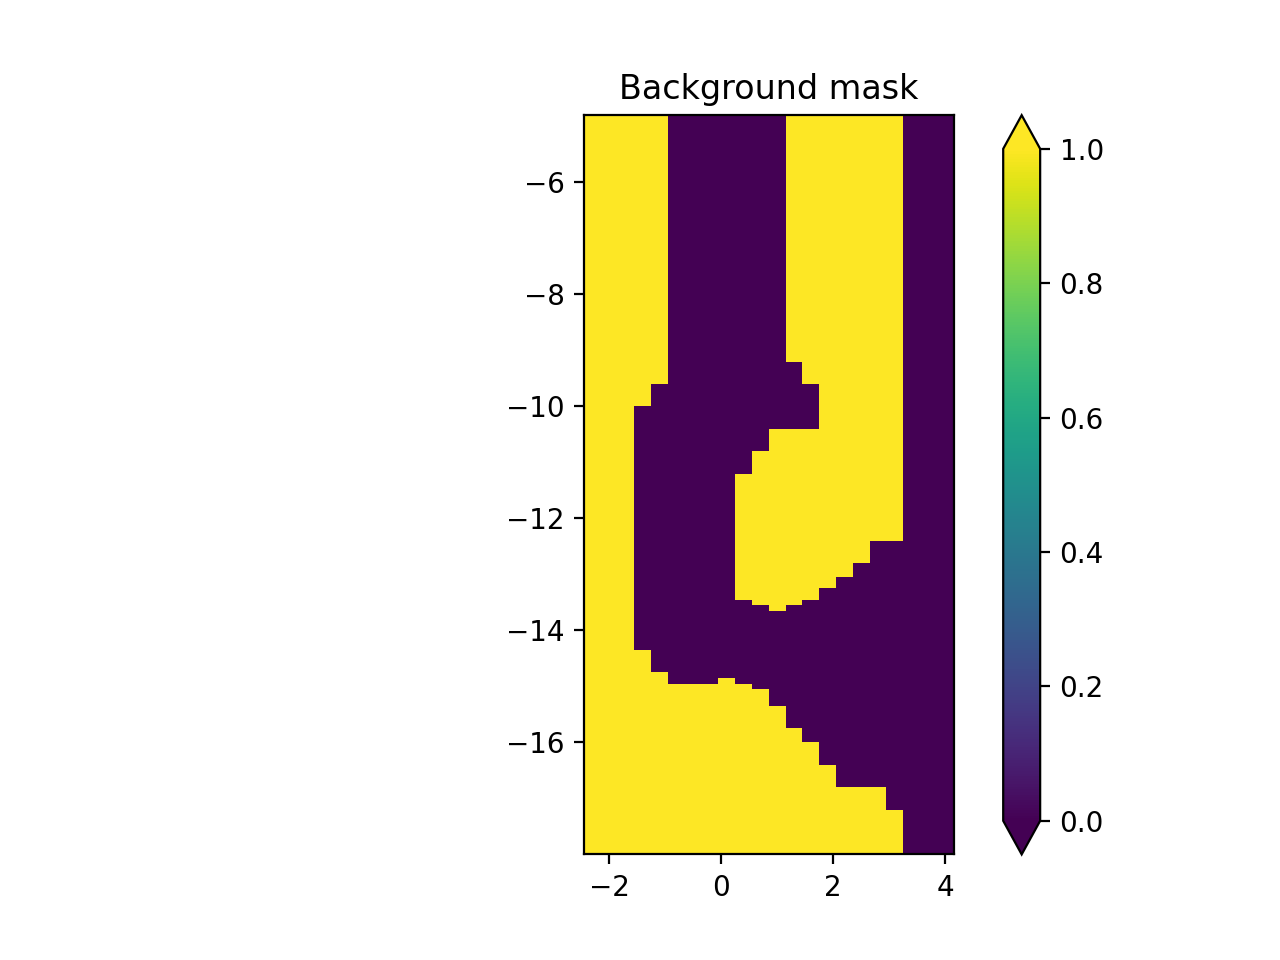

In [118]:
with h5py.File('1234 BaSO4 Canister 11.h5','r') as H:
    x = -H['SumpScans/x/Scan_4353'][...]
    y = yTransform(H['SumpScans/y/Scan_4353'][...])
    z = H['SumpScans/Ba Ka/integral/Scan_4353'][...]
    
    zBkg = z>20
    
    zBkg = skimage.morphology.dilation(zBkg,skimage.morphology.disk(2))
    zBkg = skimage.morphology.erosion(zBkg,skimage.morphology.disk(2))
    #zBkg = skimage.morphology.erosion(zBkg,skimage.morphology.disk(1))
    
    zBkg = 1-zBkg
    zBkg[x>3.1] = 0
    zBkg[(x>2)&(y<-13)&(y>-16.5)] = 0
    zBkg[(x>2.3)&(y<-12.6)&(y>-16.5)] = 0
    zBkg[(x>2.7)&(y<-12.3)&(y>-16.5)] = 0
    #zBkg[(x>1.5)&(x<3.1)&(y>-12)] = 1
    #zBkg[(y>-7.5)&(x<2.5)] = 0
    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.set_aspect(1)
    
    ph=ax.pcolormesh(x,y,zBkg)
    plt.title("Background mask")
    plt.colorbar(ph,extend='both');

## KI solutions

In [119]:
def logplot(zF_corr,applyLog=False):
    if applyLog: zF_corr = np.log10(zF_corr*(zF_corr>0) + np.nanmin(zF_corr[zF_corr>0])*(zF_corr<=0))
    else: scaled = zF_corr
    scaled[zBkg==1] = np.nan
    return scaled

<IPython.core.display.Javascript object>


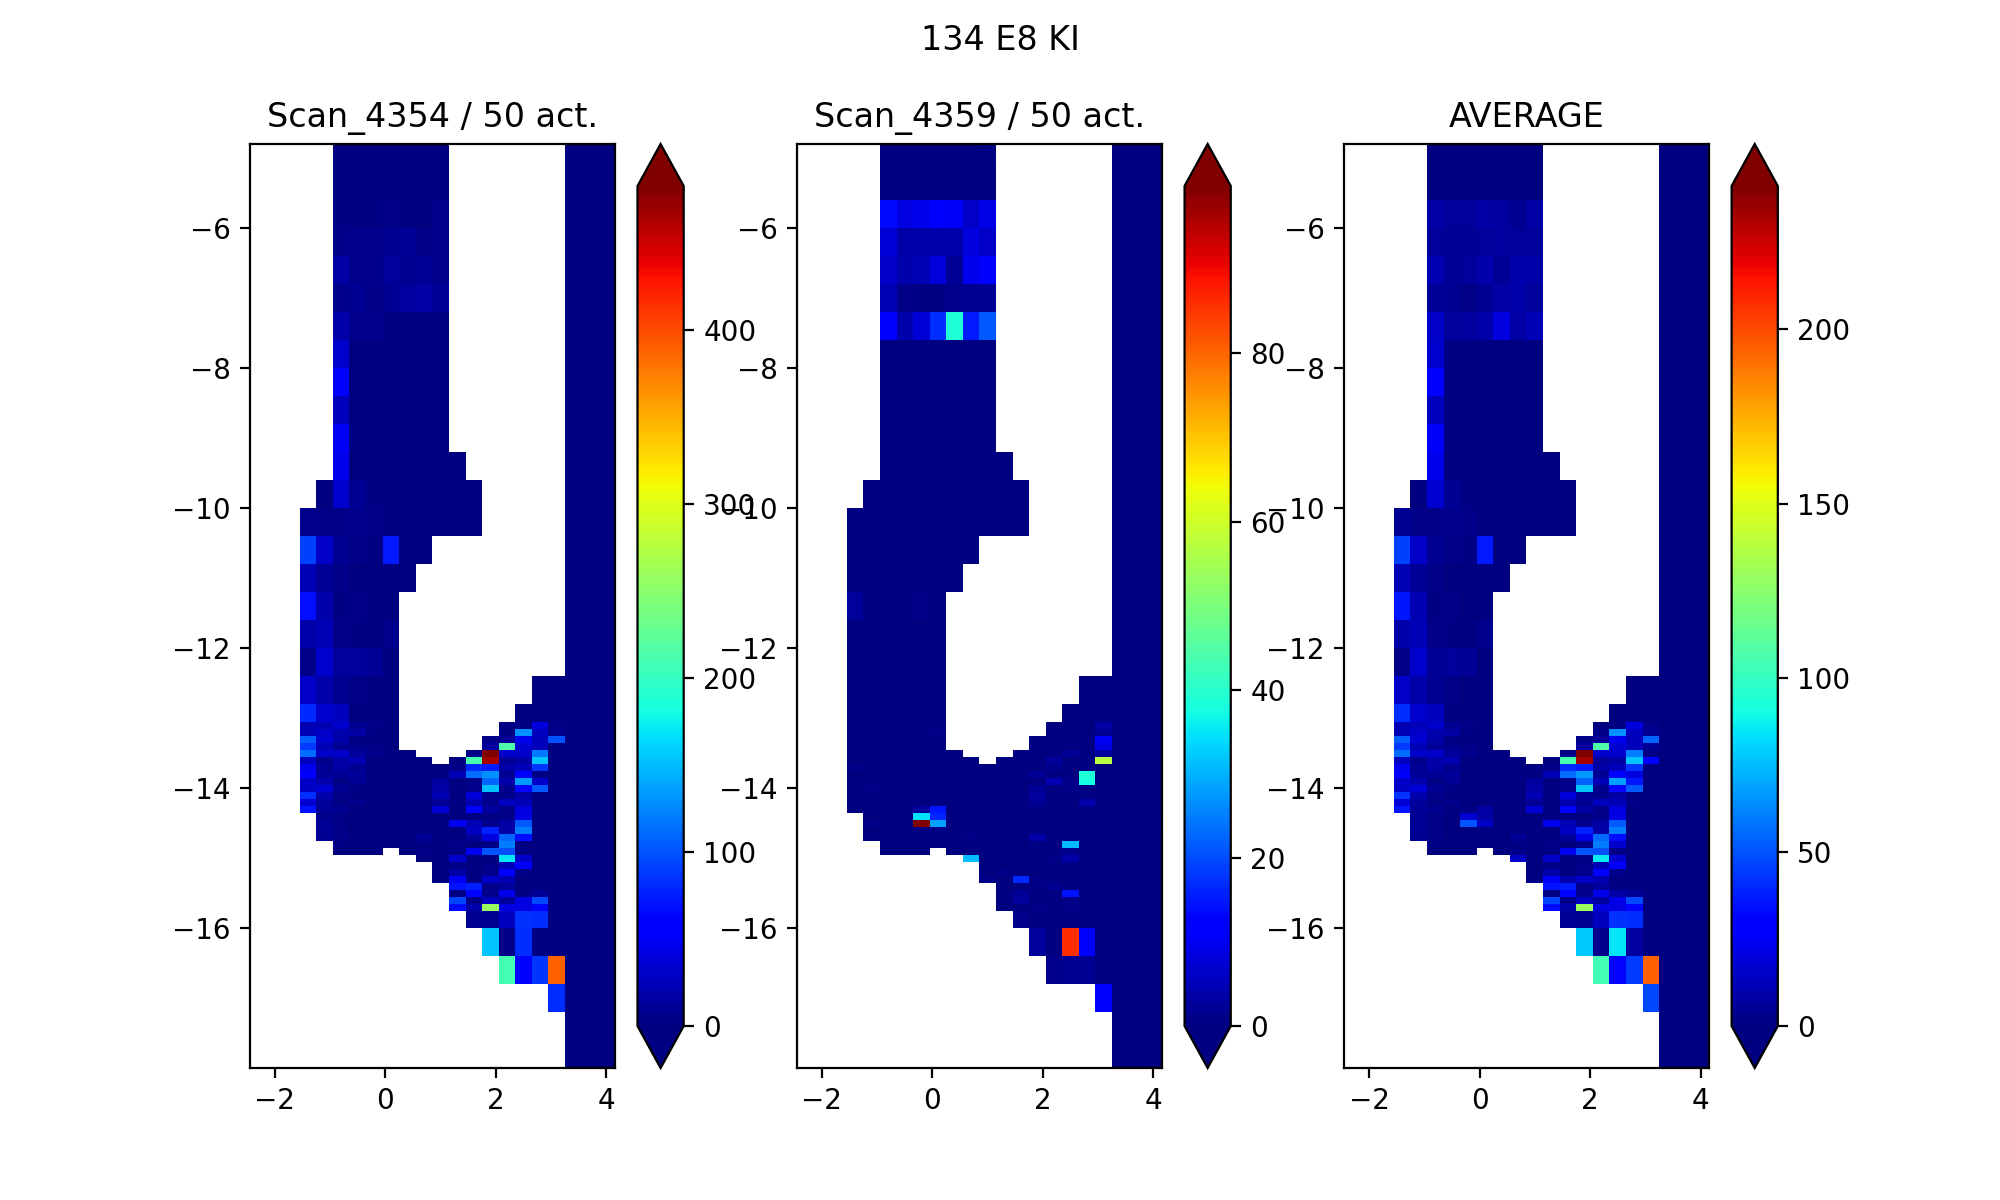

<IPython.core.display.Javascript object>


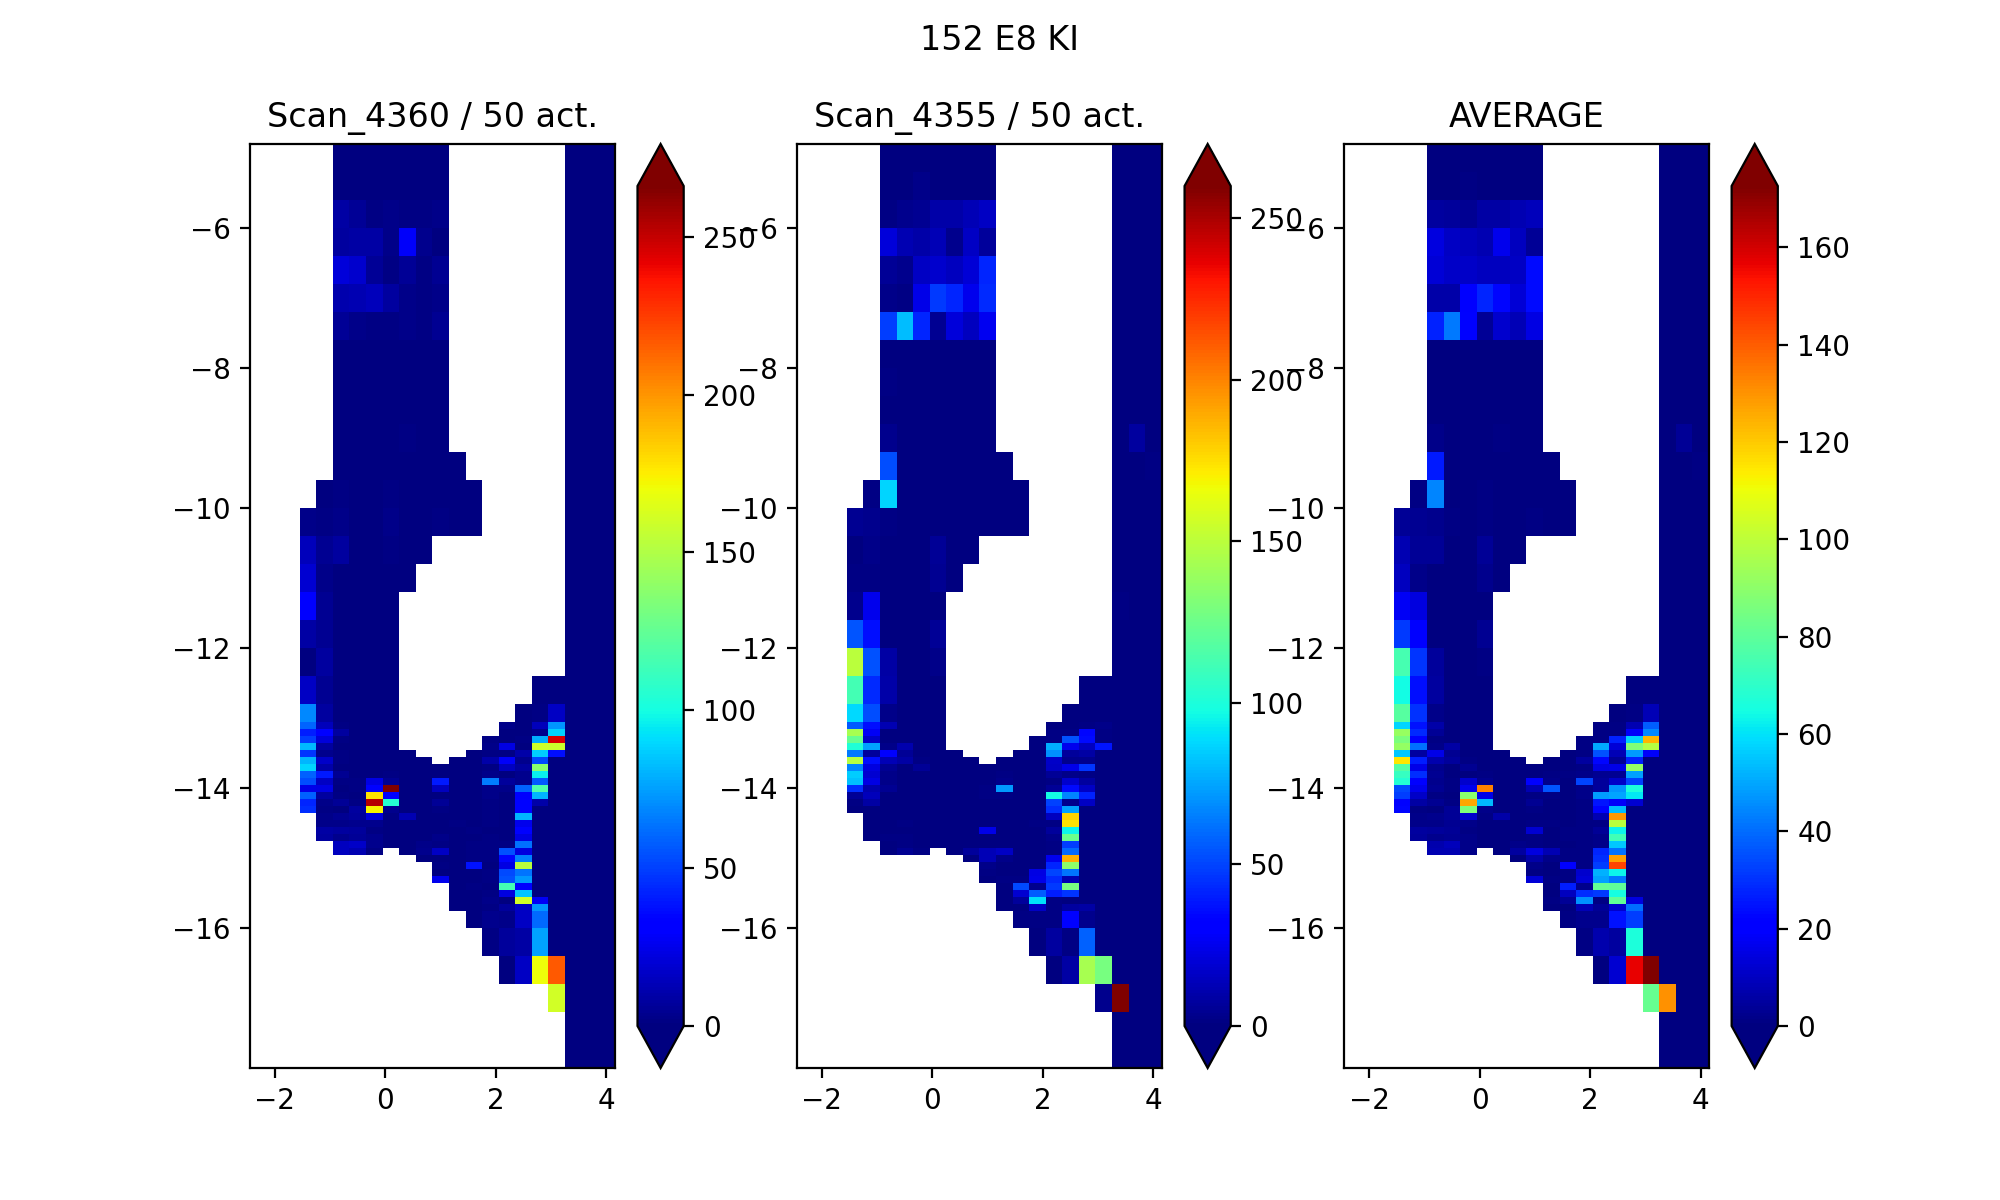

<IPython.core.display.Javascript object>


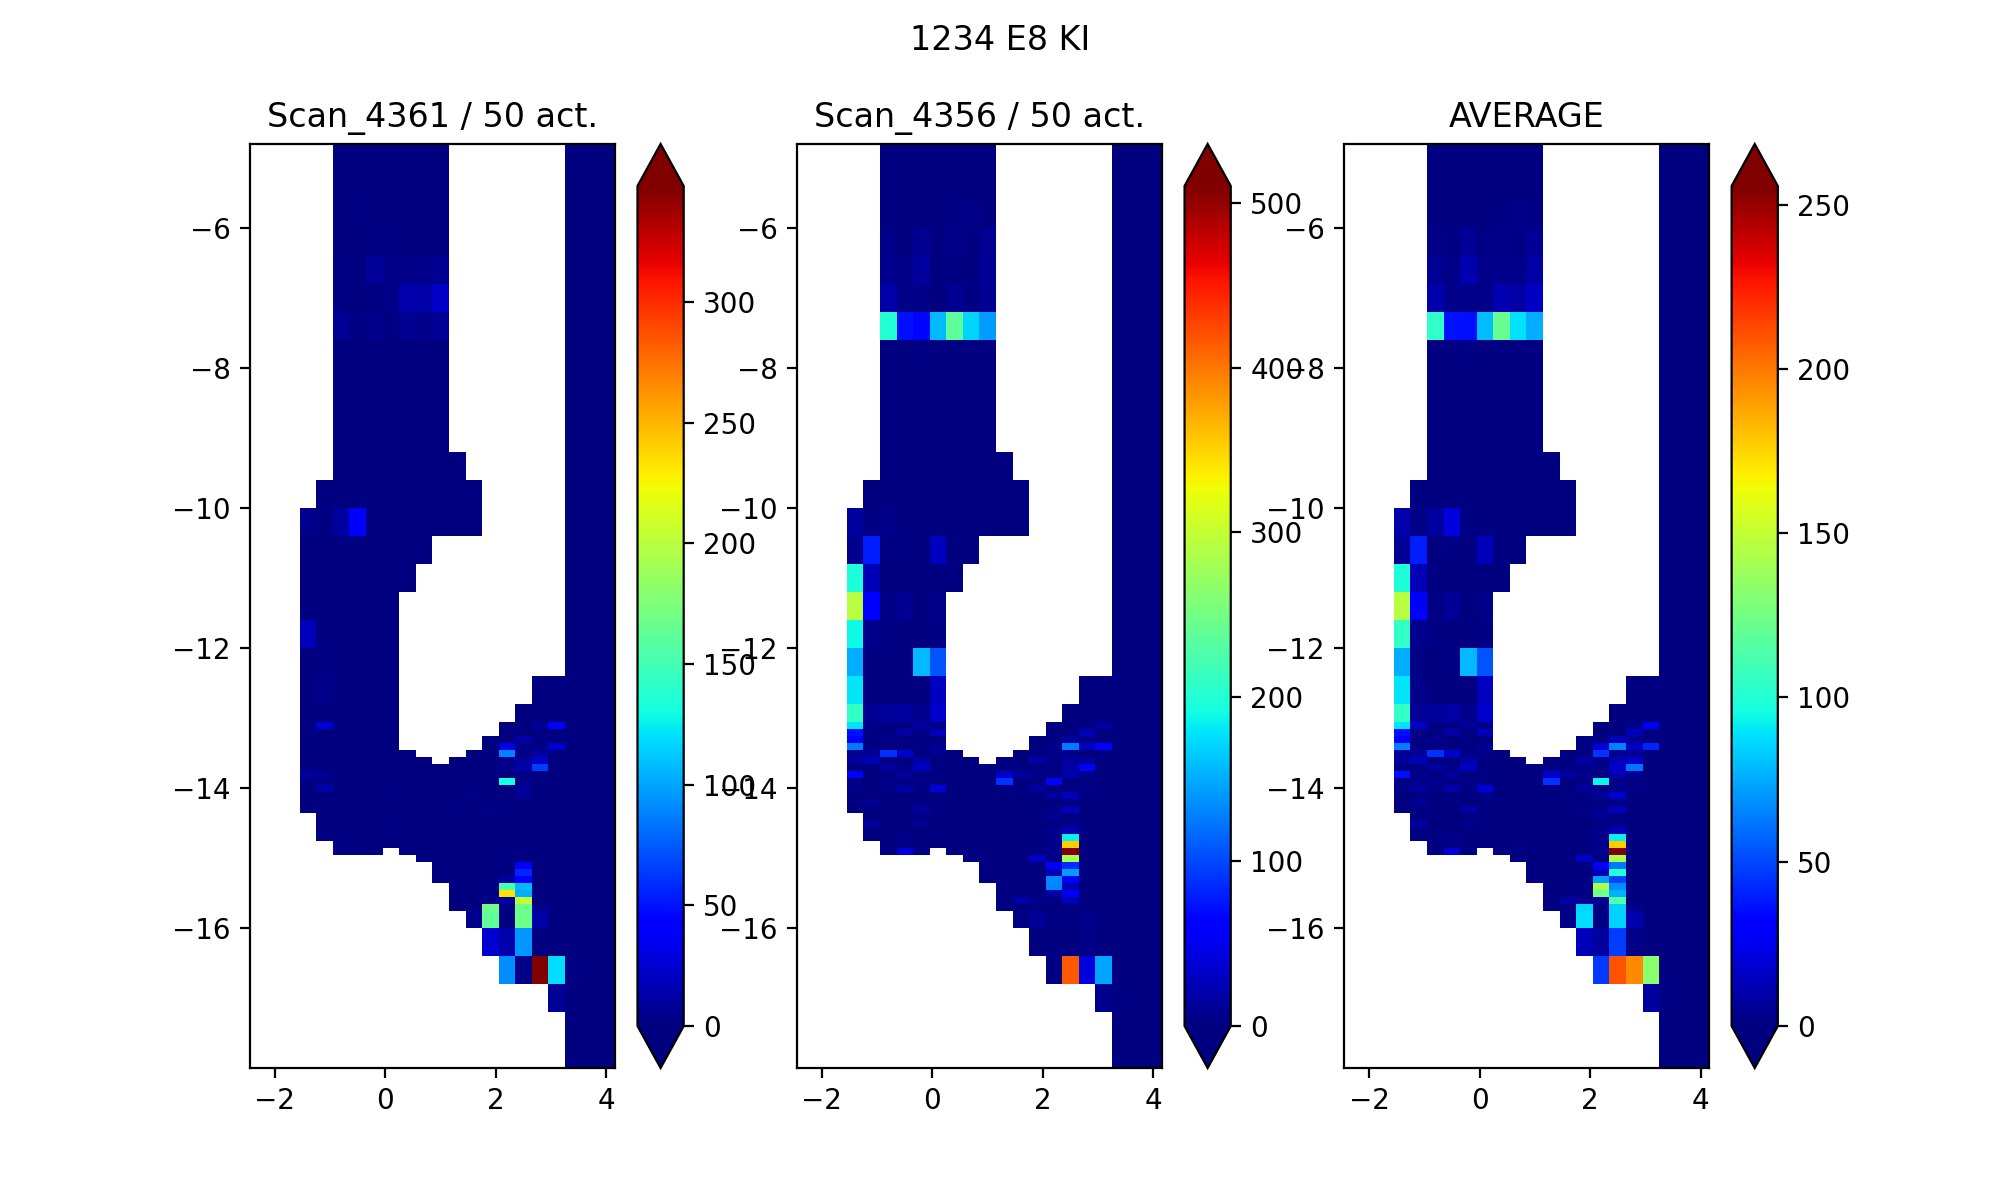

In [120]:
calibrationConstant = {'134':3.876835, '152':3.988836, '1234E':1.147466}
nplot=3
cmap=plt.cm.jet
vmin=0 #-2
vmax=None #2

for propellant in ['134','152','1234']:
    
    fig=plt.figure(figsize=(10,6))
    plt.suptitle(propellant+' E8 KI')
    i=1
    zF_avg=None
    
    filenames = glob.glob('%s E8 KI Canister*.h5' % propellant)
    for filename in filenames:
        with h5py.File(filename,'r') as H:
            if 'SumpScans' in H:
                #print('Reading',filename)
                scans = H['SumpScans/I Ka/integral']
                for s in scans:
                    #print('\t',s)

                    x = -H['SumpScans/x/'+str(s)][...]
                    y = yTransform(H['SumpScans/y/'+str(s)][...])
                    zF = H['SumpScans/I Ka/integral/'+str(s)][...]
                    zP = H['SumpScans/pinDiode/'+str(s)][...]
                    I0 = H['SumpScans/diamondMonitor/'+str(s)][...]
                    sh = H['SumpScans/shotCounter/'+str(s)][...]
                    
                    #prop=filename.split(' ')[0]
                    if propellant=='1234': prop='1234E'
                    else: prop=propellant

                    #signalTrappingCorrection, rhoFluid = applySignalTrapping(x,y,zF,zP,I0,prop)

                    zF_corr = zF  / calibrationConstant[prop] #/ signalTrappingCorrection
                    zplot = zF_corr
                    
                    ax=fig.add_subplot(1,nplot,i)
                    #ax.set_aspect(1)
                    plt.title('%s / %i act.' % (s,np.nanmax(sh)))
                    ph=ax.pcolormesh(x,y,logplot(zplot),cmap=cmap,vmin=vmin,vmax=vmax)
                    plt.colorbar(ph,extend='both');
                    
                    # Make ensemble-average, assume no change in X & Y positions.
                    if zF_avg is None: zF_avg = zplot[...]
                    else: zF_avg += zplot
                    
                    i+=1

    ax=fig.add_subplot(1,nplot,nplot)
    #ax.set_aspect(1)
    plt.title('AVERAGE')
    ph=ax.pcolormesh(x,y,logplot(zF_avg/float(i-1)),cmap=cmap,vmin=vmin,vmax=vmax)
    plt.colorbar(ph,extend='both');

## BaSO4 suspensions

In [121]:
# Apply calibration constant
def BaSO4Calib(filename):
    k = os.path.splitext(filename)[0].split(' ')
    can = k[0] + ' ' + k[3]
    if can == '134 5':  mgPerMl=2.031935023
    elif can == '134 7': mgPerMl=1.980974346
    elif can == '134 8': mgPerMl=1.964511478
    elif can == '152 7': mgPerMl=1.907710075
    elif can == '152 8': mgPerMl=1.895996174
    elif can == '152 9': mgPerMl=1.928946645
    elif can == '152 10': mgPerMl=1.914201976
    elif can == '1234 11': mgPerMl=2.021622565
    elif can == '1234 12': mgPerMl=2.013647655
    elif can == '1234 13': mgPerMl=2.018068088
    else: raise KeyError("unknown canister `%s`" % can)
   
    return 6000./(mgPerMl*11.5*2)

<IPython.core.display.Javascript object>


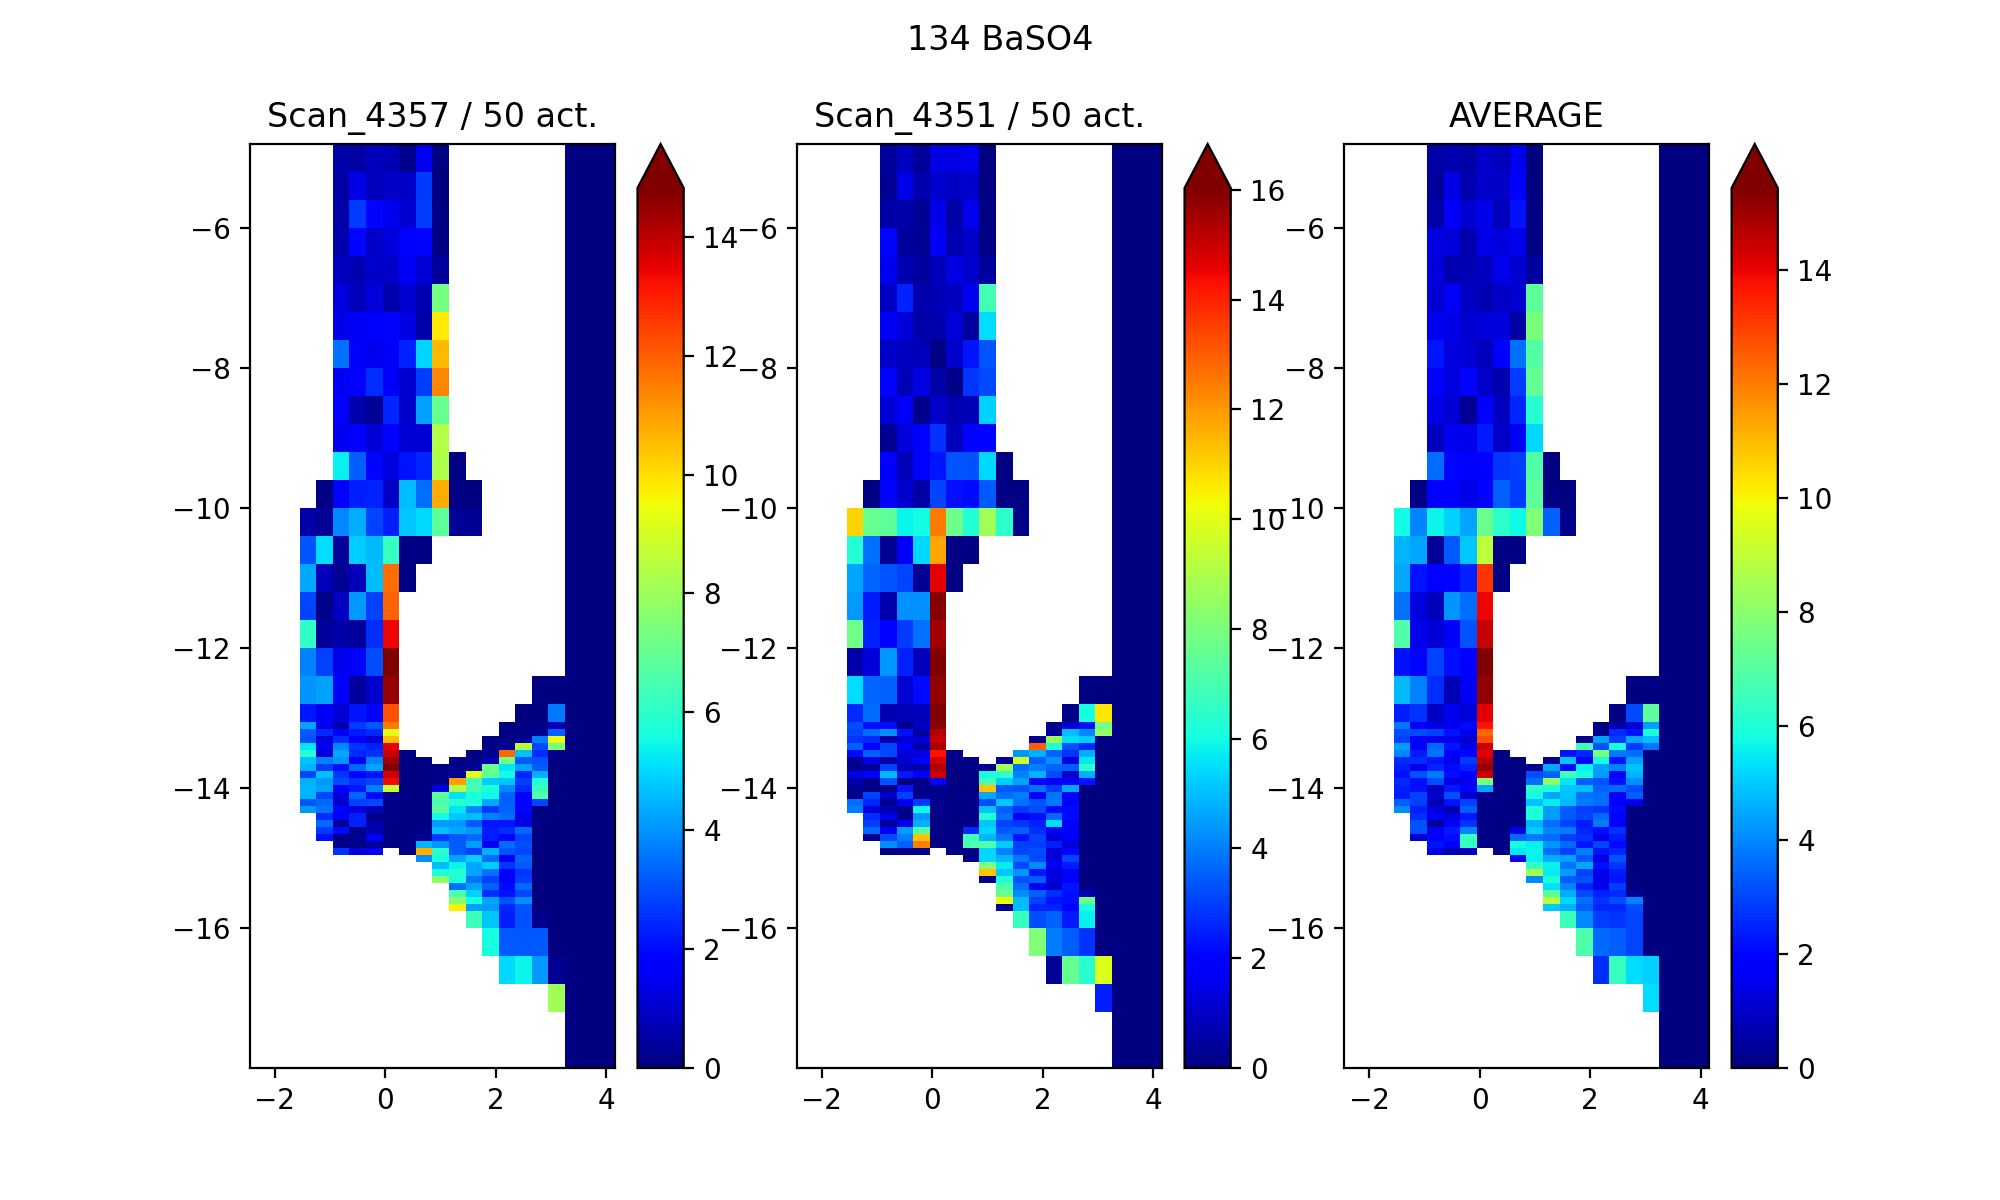

<IPython.core.display.Javascript object>


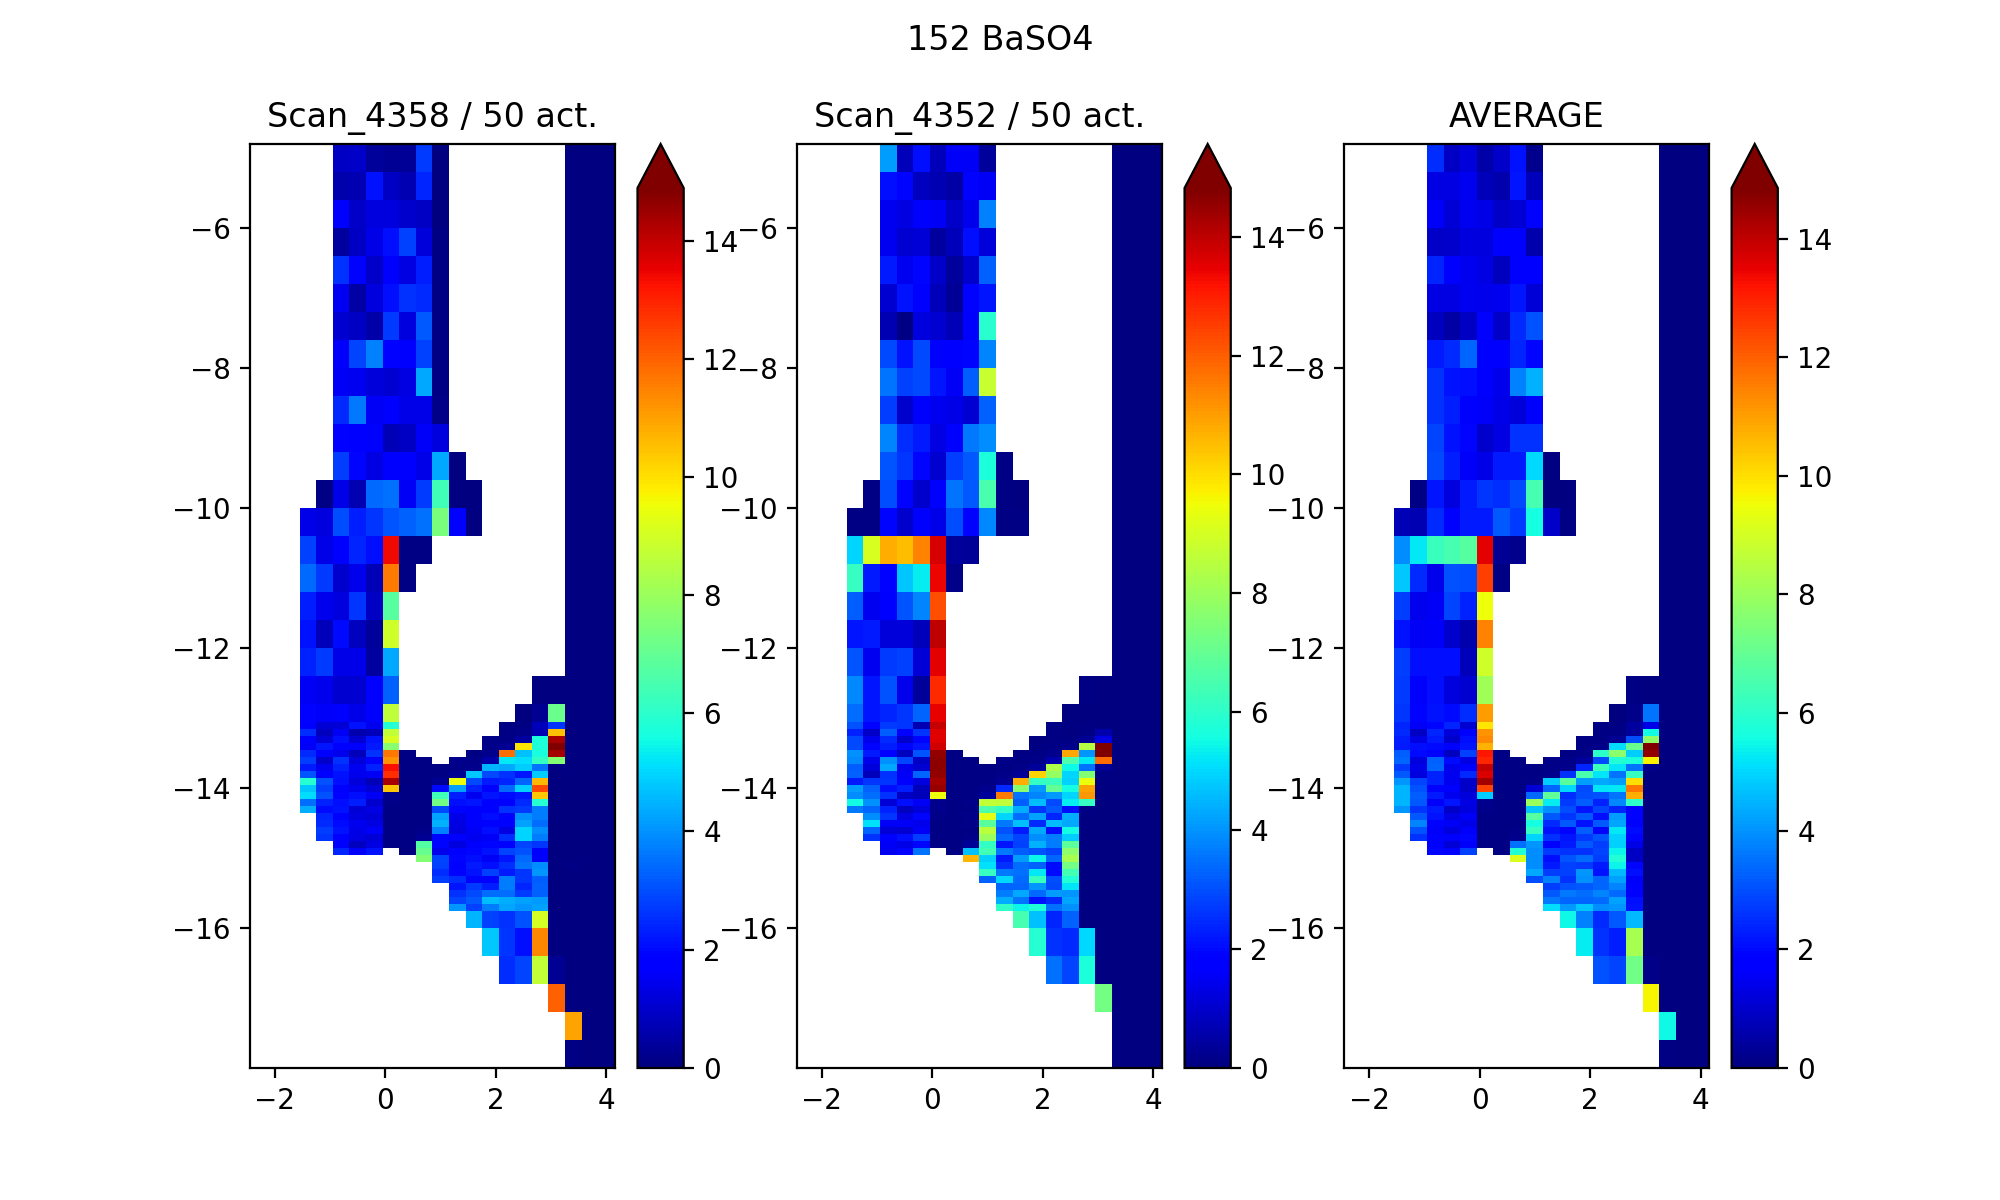

<IPython.core.display.Javascript object>


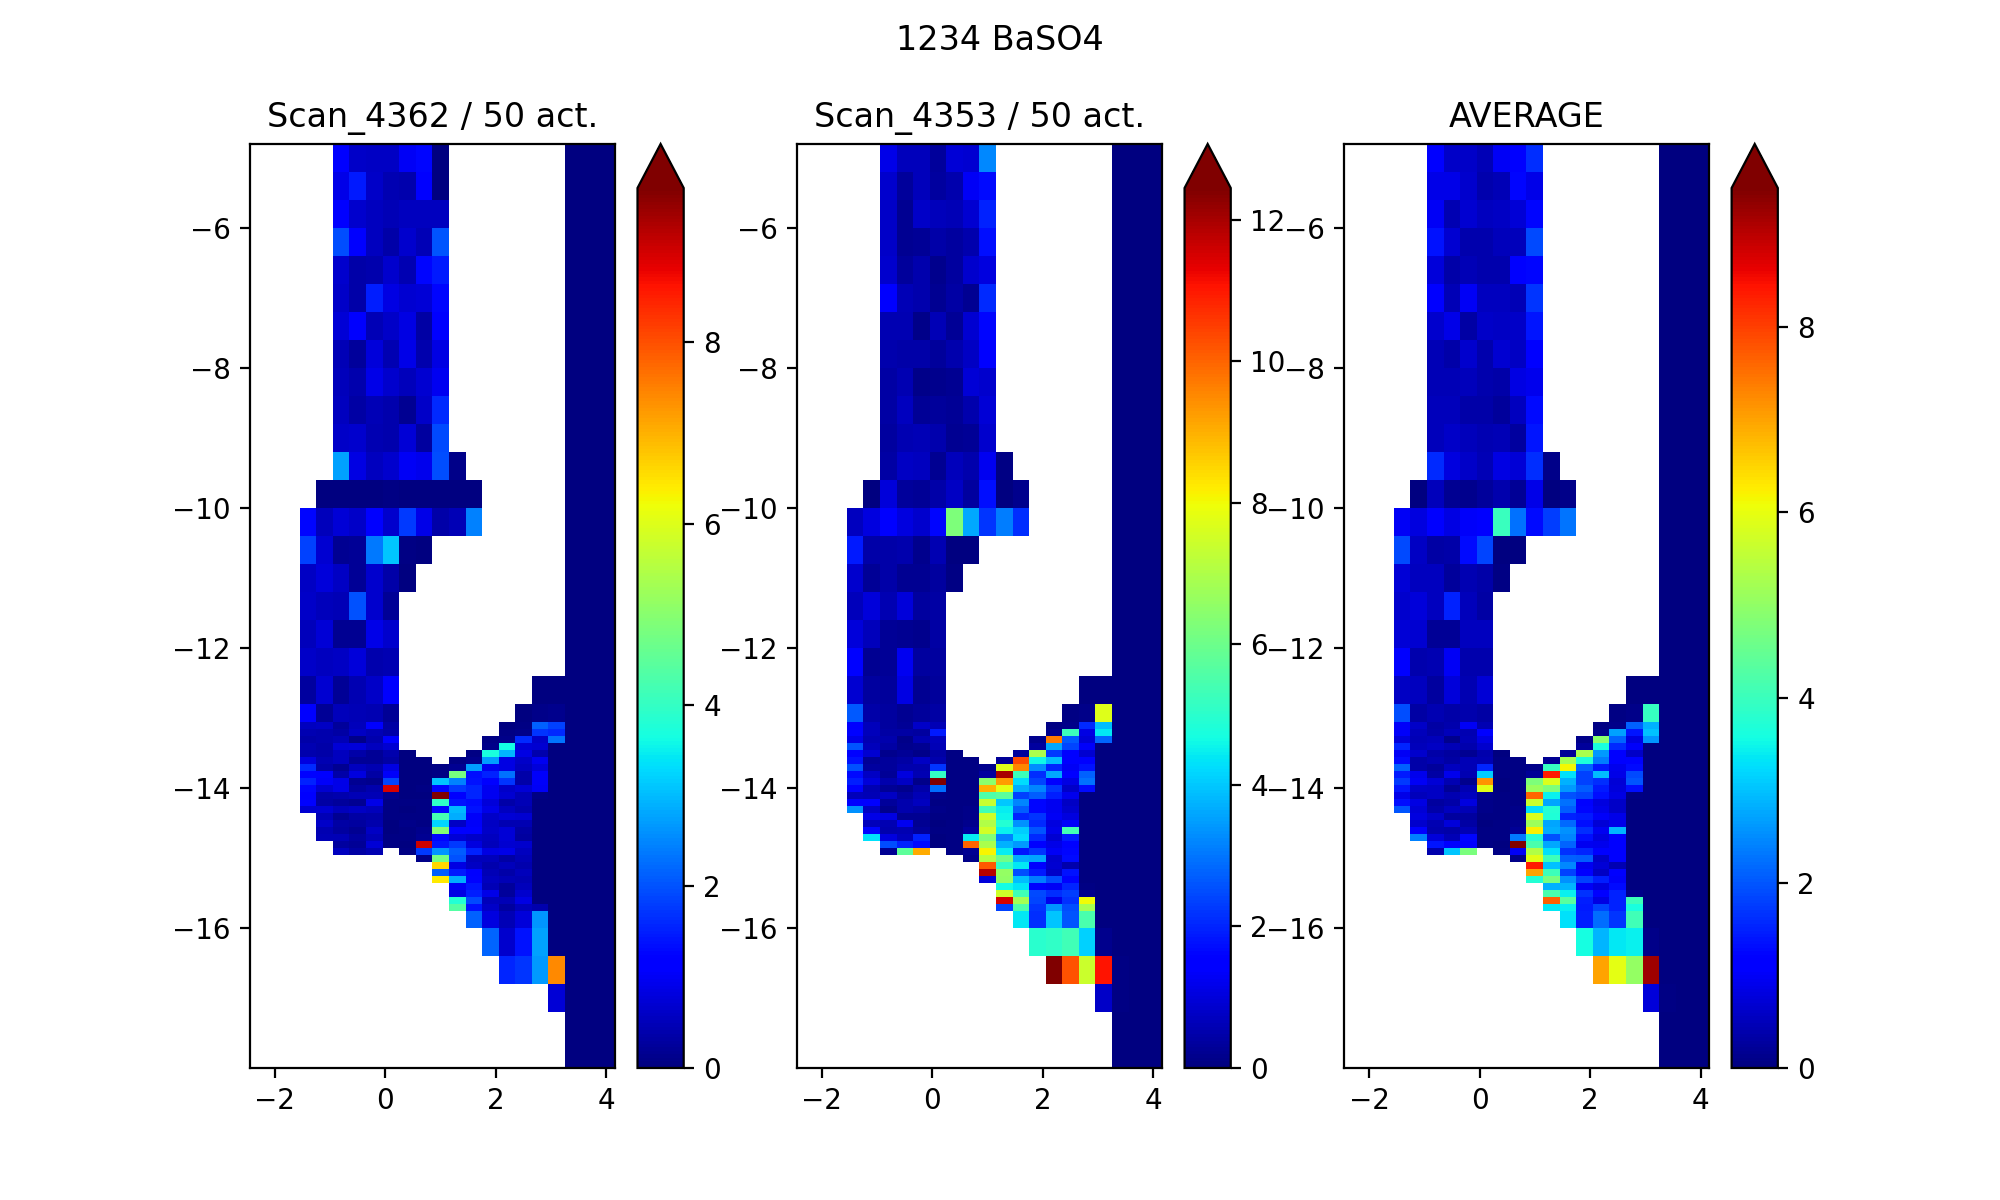

In [122]:
nplot=3
cmap=plt.cm.jet
vmin=None
vmax=None

for propellant in ['134','152','1234']:
    
    fig=plt.figure(figsize=(10,6))
    plt.suptitle(propellant+' BaSO4')
    i=1
    zF_avg=None
    
    filenames = glob.glob('%s BaSO4 Canister*.h5' % propellant)
    for filename in filenames:
        with h5py.File(filename,'r') as H:
            if 'SumpScans' in H:
                #print('Reading',filename)
                scans = H['SumpScans/Ba Ka/integral']
                for s in scans:
                    #print('\t',s)

                    x = -H['SumpScans/x/'+str(s)][...]
                    y = yTransform(H['SumpScans/y/'+str(s)][...])
                    zF = H['SumpScans/Ba Ka/integral/'+str(s)][...]
                    zP = H['SumpScans/pinDiode/'+str(s)][...]
                    I0 = H['SumpScans/diamondMonitor/'+str(s)][...]
                    sh = H['SumpScans/shotCounter/'+str(s)][...]
                    
                    #prop=filename.split(' ')[0]
                    if propellant=='1234': prop='1234E'
                    else: prop=propellant

                    #signalTrappingCorrection, rhoFluid = applySignalTrapping(x,y,zF,zP,I0,prop)

                    zF_corr = zF  / BaSO4Calib(filename) #/ signalTrappingCorrection
                    zplot = zF_corr

                    ax=fig.add_subplot(1,nplot,i)
                    #ax.set_aspect(1)
                    plt.title('%s / %i act.' % (s,np.nanmax(sh)))
                    ph=ax.pcolormesh(x,y,logplot(zplot),cmap=cmap,vmin=vmin,vmax=vmax)
                    plt.colorbar(ph,extend='max');
                    
                    # Make ensemble-average, assume no change in X & Y positions.
                    if zF_avg is None: zF_avg = zplot[...]
                    else: zF_avg += zplot
                    
                    i+=1

    ax=fig.add_subplot(1,nplot,nplot)
    #ax.set_aspect(1)
    plt.title('AVERAGE')
    ph=ax.pcolormesh(x,y,(zF_avg/float(i-1)),cmap=cmap,vmin=vmin,vmax=vmax)
    plt.colorbar(ph,extend='max');